![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )

# Optimization of cycles on surfaces

In this Python 2 notebook we use MOSEK Fusion to solve some geometric optimization problems on surfaces. The code demonstrates setting up a linear optimization problem, extending the `Model` class, reoptimization with different parameters and shows the practical difference between interior-point and basic solution.

#### Requirements

In [14]:
%matplotlib notebook
import mosek                             # Mosek version >= 8.0.0.55
from mosek.fusion import *
import numpy as np 
import sys, io, math, urllib2, plyfile
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

<a href="https://pypi.python.org/pypi/plyfile">`plyfile`</a> is a package for reading the descriptions of surfaces in <a href="https://en.wikipedia.org/wiki/PLY_(file_format)">PLY format</a>. It can be installed with `pip install plyfile`.

You will also need some data files with examples used in this presentation. The complete code and additional files are available from <a href="https://github.com/MOSEK/Tutorials/tree/master/Fusion/surfacecycles">GitHub</a>.

In [15]:
#Fetching examples predefined for this presentation
def getExample(name):
    if name=='mug.ply':
        fname = 'http://people.sc.fsu.edu/~jburkardt/data/ply/mug.ply'
    else:
        fname = 'https://raw.githubusercontent.com/MOSEK/Tutorials/master/Fusion/surfacecycles/' + name
    return plyfile.PlyData.read(urllib2.build_opener().open(urllib2.Request(fname)))
def getCycleExample(name):
    return np.load(np.DataSource().open(
        'https://raw.githubusercontent.com/MOSEK/Tutorials/master/Fusion/surfacecycles/'+name))

#### References
One of the models used in this tutorial comes from <a href="http://people.sc.fsu.edu/~jburkardt/data/ply/ply.html">John Burkardt's</a> library of PLY files and the other ones were generated using <a href="http://www.cgal.org/">CGAL</a>. A comprehensive survey of topological optimization problems can be found in the <a href="http://jeffe.cs.illinois.edu/pubs/pdf/optcycles.pdf">survey paper</a> by Jeff Erickson. The model used in this tutorial comes from the paper <a href="https://arxiv.org/abs/1001.0338">Optimal Homologous Cycles, Total Unimodularity, and Linear Programming</a> by Dey, Hirani and Krishnamoorthy. The experts in the field are kindly asked to fill in some vague statements in the following text with the precise algebro-topological language on their own.

## A crash-course in homotopy
A triangulated surface is a mesh of 2D triangles in 3D that fit together to form a surface. The vertices and edges of a triangulation form a graph. The *cycles* in that graph can be used to detect interesting *topological features*. For an example of what that means, see the three loops on the surface below:

![](https://raw.githubusercontent.com/MOSEK/Tutorials/master/Fusion/surfacecycles/surface1.png )

Now imagine that each loop is a rubber band that can be stretched in a continuous way and slide on the surface. Then the violet loop is not very interesting - it lies in a small patch of the surface and if we start shrinking it, it will collapse to a point (in other words, it is *contractible*). The yellow loop is different - it circles around a hole in the surface, and no matter how much we deform it, it will not disappear. We say this loop *detects a feature* - in this case the feature is one of the holes. The red loop has the same property. Moreover, the yellow and red loops are *homotopic* - each of them can be continuosly moulded into the second one - i.e. they detect the same feature (hole).

In some applications it is useful to have *small* representations of topological features, in this case the shortest possible loops in a given homotopy class. There are at least two reasonable ways of measuring the length of a path on a surface: with the Euclidean metric on the edges, or just counting the number of edges.

In [16]:
#Two ways of assigning edge weights
def euclideanM(x, y):
    return math.sqrt(sum([(x[i]-y[i])**2 for i in range(3)]))
def graphM(x,y):
    return 1

## First problem: shortest equivalent representation of a cycle
Suppose the surface has $v$ vertices, $e$ edges and $t$ triangles. It is convenient to represent it by *boundary matrices*, which are just variants of the <a href="https://en.wikipedia.org/wiki/Incidence_matrix">incidence matrix of a graph</a>. Specifically, we have a linear map $D_1:\mathbb{R}^e\to\mathbb{R}^v$ given on the basis vectors by:

$$D_1(\mathbf{e}_{ij})=\mathbf{e}_j-\mathbf{e}_{i}$$

and we identify $D_1\in \mathbb{R}^{v\times e}$ with the matrix of this map. Similarly, we can record the incidence between triangles and edges by $D_2:\mathbb{R}^t\to\mathbb{R}^e$:

$$D_2(\mathbf{e}_{ijk})=\mathbf{e}_{jk}-\mathbf{e}_{ik}+\mathbf{e}_{ij}$$

and let $D_2\in \mathbb{R}^{e\times t}$ be its matrix. We refer to <a href="https://en.wikipedia.org/wiki/Simplicial_homology">other sources</a> for more details. Note that matrices $D_1,D_2$ are extremely sparse - they have just two, resp. three, nonzeros in each column.

### Shortest homologous cycle problem
A *chain* (more precisely, *1-chain*) is just a vector $c\in \mathbb{R}^e$, that is an assignment of a real coefficient to every edge. If $c$ is an actual path or cycle in the graph, then these coefficients are $\pm1$ for edges in the cycle, and $0$ otherwise, but more general chains are allowed. We will mostly concentrate on cycles.

We can now formulate the following problem: given a cycle $c\in\mathbb{R}^e$, find the shortest cycle that detects the same topological features as $c$ (strictly speaking, the shortest cycle *homologous* to $c$). Suppose $w_1,\ldots,w_e$ are the weights (lengths) of the edges.

$$
\begin{array}{ll}
\textrm{minimize}   & \sum_{i=1}^e w_i|x_i| \\
\textrm{subject to} & x-c=D_2y \\
                    & x\in\mathbb{R}^e, y\in\mathbb{R}^t
\end{array}
$$

### Implementation
This optimization problem can easily be formulated as a linear program. Below is the implementation of this program in a class `Surface`, which extends a Mosek Fusion `Model`.

In [17]:
#A model of a surface (or a more general 2D complex in 3D)
class Surface(mosek.fusion.Model):
    #Initialize from plydata using edge weights given by metric
    def __init__(self, plydata, metric):
        super(Surface, self).__init__()

        ### Initialize basic data
        self.v = plydata.elements[0].count                              # number of vertices
        self.t = plydata.elements[1].count                              # number of triangles
        self.coo = plydata['vertex']                                    # coordinates of vertices in 3D
        self.xc, self.yc, self.zc = zip(*self.coo)
        self.tri = [tuple(sorted(f[0])) for f in plydata['face']]       # list of triangles, as sorted triples of vertices
        self.edg = list(set([tuple(sorted([f[i],f[j]]))                 # list of edges, as sorted pairs of vertices
            for f in self.tri for i,j in [(0,1),(0,2),(1,2)]]))
        self.e = len(self.edg)                                          # number of edges
        self.wgh = [metric(self.coo[f[0]],self.coo[f[1]])               # weights of edges
            for f in self.edg]

        ### Homological algebra
        # Construct the sparse matrix D2
        d1 = [ (self.edg[i][k], i, sgn) for i in range(self.e) for k,sgn in [(1,+1),(0,-1)] ]
        s1, s2, val = zip(*d1)
        self.D1 = Matrix.sparse(self.v, self.e, list(s1), list(s2), list(val))
        # Construct the sparse matrix D3
        d2 = [ (self.edg.index((self.tri[i][k],self.tri[i][l])), i, sgn) 
            for i in range(self.t) for k,l,sgn in [(1,2,+1),(0,2,-1),(0,1,+1)] ]
        s1, s2, val = zip(*d2)
        self.D2 = Matrix.sparse(self.e, self.t, list(s1), list(s2), list(val))

        ### Set up a MOSEK Fusion model for solving shortest homologous cycles
        x    = self.variable(self.e, Domain.unbounded())                # the chain we are looking for
        xabs = self.variable(self.e, Domain.unbounded())                # absolute value of x
        y    = self.variable(self.t, Domain.unbounded())                # a 2-chain whose boundary is x-C
        C    = self.variable(self.e, Domain.unbounded())                # the input chain

        # -xabs <= x <= xabs
        self.constraint(Expr.add(xabs, x), Domain.greaterThan(0))
        self.constraint(Expr.sub(xabs, x), Domain.greaterThan(0))

        # x - c = D2*y, so x-c is a boundary
        self.constraint(Expr.sub(Expr.sub(x, C), Expr.mul(self.D2, y)), Domain.equalsTo(0))

        # min weighted 1-norm of x
        self.objective(ObjectiveSense.Minimize, Expr.dot(self.wgh, xabs))

        # Save the model for later cloning
        self.x, self.c, self.C = x, self.constraint(C, Domain.equalsTo(0)), 0

    #Plot the surface and a number of chains
    def plot(self, chains=[], colors=[]):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(self.xc, self.yc, self.zc, triangles=self.tri, linewidth=0.5, alpha=1.0, edgecolor='green')
        i = 0
        for C in chains:
            for j in range(self.e):
                if abs(C[j])>0.0001:
                    # Extract the edge and plot with intensity depending on its coefficient in C
                    xc,yc,zc = zip(*[ self.coo[self.edg[j][0]], self.coo[self.edg[j][1]] ])
                    ax.plot(xc, yc, zc, color=colors[i], alpha=min(1,abs(C[j])))
            i += 1
        plt.axis('off')
        plt.show()

    #Find the shortest chain homologous to a given chain C
    def short(self, C):
        # We add a constraint c=C to the model
        # This is a little hack, because we must remember the old C
        self.c.add(self.C-C)
        self.C = C
        self.solve()
        return self.x.level()

The inititlization part processes the PLY description of the surface, initializes the sparse boundary matrices and sets up a linear program with the parameter $c$ as a variable. In subsequent optimizations (the method `short`) $c$ is set to the actual input cycle.

### Example
We predefined the yellow cycle on the mug, and Mosek finds the red cycle - its shortest topological equivalent.

<IPython.core.display.Javascript object>


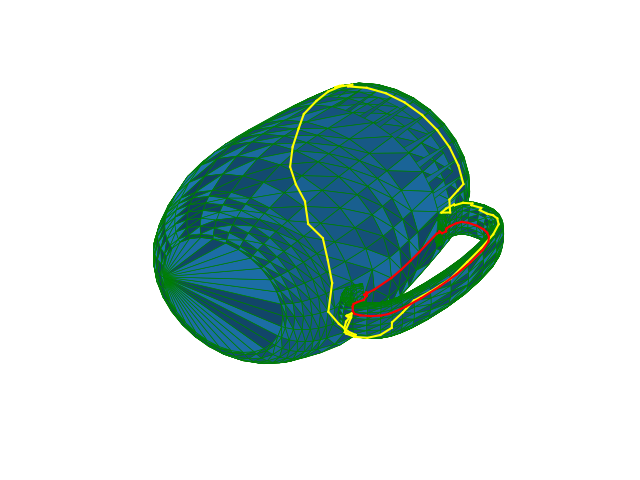

In [18]:
S = Surface(getExample('mug.ply'), euclideanM)
C = getCycleExample('mug-C1.npy')
C1= S.short(C)
S.plot([C, C1], ['yellow', 'red'])

Indeed, if we again imagine the yellow loop is made out of rubber, then once it starts contracting it will reach its minimum length when it sits tightly around the mug's handle.

## Detecting features
OK, but what if we don't have any predefined cycle, and we would simply like to visualize all topological features on a given input surface using shortest possible loops? In general, this is a hard problem, for which some algorithms are known on surfaces. However, we can use our model to try a more pedestrian approach, which is not perfect, but often good enough for visualization.

Without going into too much algebra, the space of features on the surface can be identified with the nullspace of the matrix $$A=\left[\begin{array}{l} D_1 \\ D_2^T\end{array}\right]$$ (for the experts, we are now computing first homology with real coefficients). This can be easily found using singular value decomposition:

In [19]:
#Find the basis for the nullspace of a matrix
def nullspace(A):
    u, s, vh = np.linalg.svd(A)
    nnz = (s >= 1e-13).sum()
    ns = vh[nnz:].conj().T
    return ns, ns.shape[1]

def homology(S):
    return nullspace(np.reshape(
        np.concatenate((S.D1.getDataAsArray(), S.D2.transpose().getDataAsArray())),
        [S.v+S.t, S.e]))

For an orientable surface the dimension of the nullspace of $A$ equals $2g$, where $g$ is the <a href="https://en.wikipedia.org/wiki/Genus_(mathematics)">genus</a>, or the number of holes. For example, the torus has one hole and two essential features: the parallel and the meridian cycle.

Since the SVD decomposition is oblivious to the underlying geometry, the chains it returns are typically dense vectors with real coordinates, not very useful for visualization. However, we can replace them with their shortest equivalents and see if they are any better. It turns out in practice they often are. To make this easier to see we also normalize so that the maximal coefficient of each chain is 1.

<IPython.core.display.Javascript object>


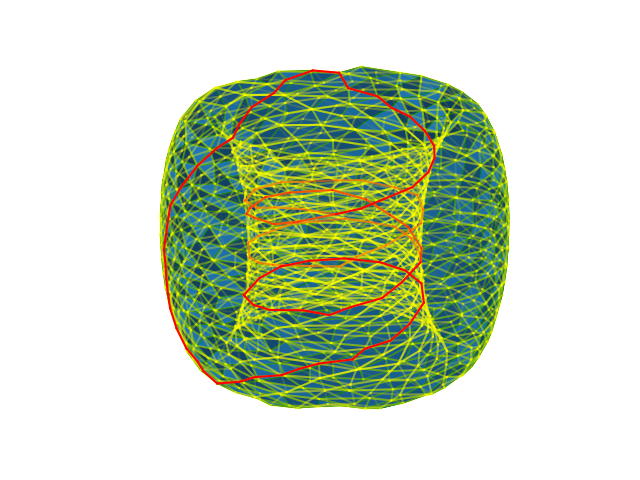

<IPython.core.display.Javascript object>


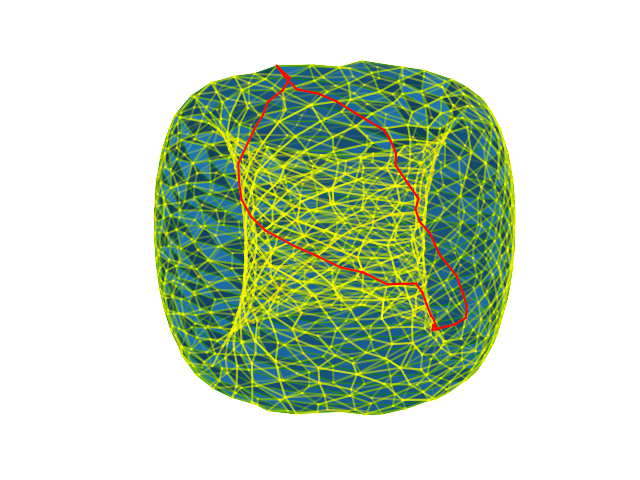

In [20]:
#Normalize a chain so that l_\infty norm is 1
def normalize(C):
    return C/max(abs(C))

S = Surface(getExample('torus.ply'), euclideanM)
generators, betti1 = homology(S)

G = [ normalize(generators[:,i]) for i in range(betti1) ]
GS= [ normalize(S.short(g)) for g in G ]

for i in range(betti1):
    S.plot([G[i], GS[i]], ['yellow', 'red'])

The two projections of the torus do not reveal where the holes are. In yellow we see the dense cycles found by SVD.  Their shortest homologous red versions make this a bit more clear. For example, the coil-shaped part of the first cycle clearly detects the hole in the middle of the torus.

Here is an example of this on a more complicated surface.

Number of features:  6


<IPython.core.display.Javascript object>


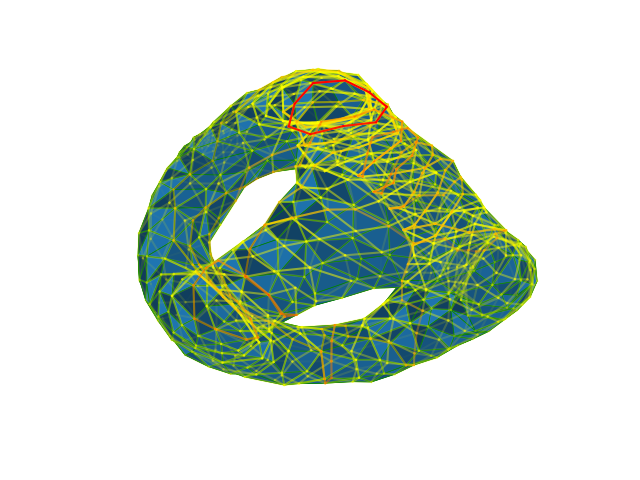

<IPython.core.display.Javascript object>


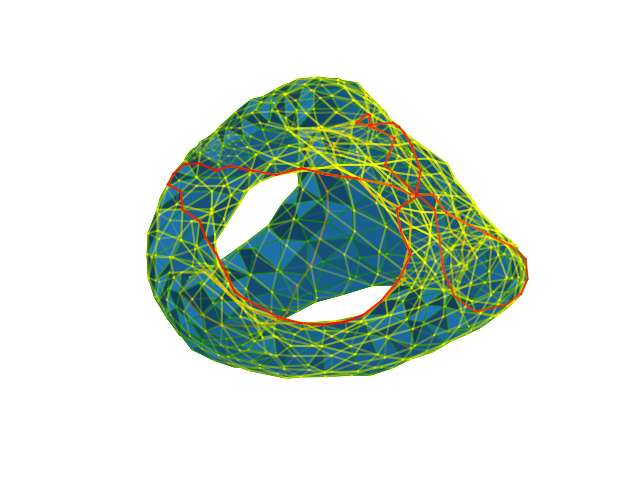

In [21]:
S = Surface(getExample('surface.ply'), euclideanM)
generators, betti1 = homology(S)
print "Number of features: ", betti1

G = [ normalize(generators[:,i]) for i in range(betti1) ]
for i in [2,5]:
    S.plot([G[i], normalize(S.short(G[i]))], ['yellow', 'red'])


## One more example: interior point vs. basic solution
Here is a demonstration of a (reasonably) practical situation where we can see the interior point and basic solutions. Suppose we solve the problem on the mug again, this time using the discrete metric where every edge has weight 1, and we explicitly ask for the result of interior point optimization.

<IPython.core.display.Javascript object>


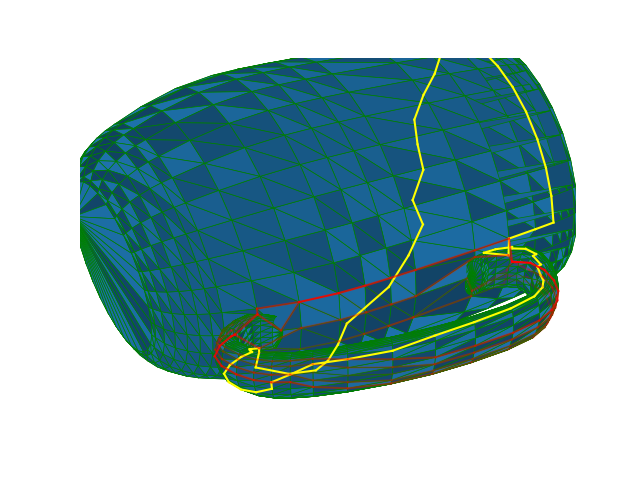

In [22]:
S = Surface(getExample('mug.ply'), graphM)
C = getCycleExample('mug-C1.npy')
S.setSolverParam("intpntBasis", "never")
S.plot([C, normalize(S.short(C))], ['yellow', 'red'])

We don't get a single cycle any more, instead we have a collection of cycles. This happens because there are many shortest cycles of the same length in this homology class, and the interior point optimizer converges to some convex combination of all of them. If we ask for a basic solution instead, we get one of those cycles - which one can depend on many factors, such as the order in which the triangles are listed in the model. In particular it should not be surprising that different basic solutions can be returned in different circumstances.

<IPython.core.display.Javascript object>


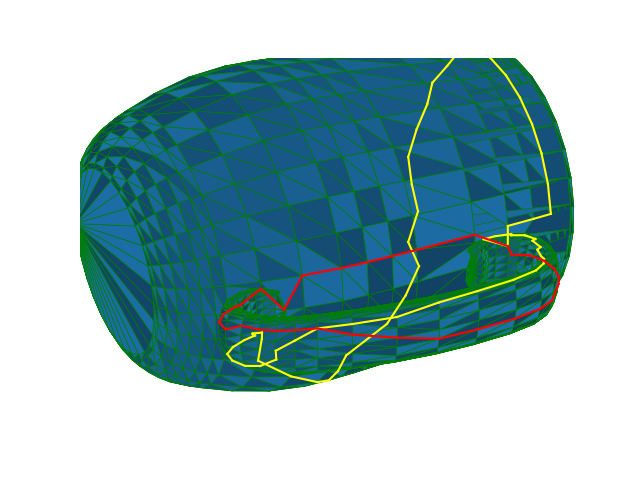

In [23]:
S = Surface(getExample('mug.ply'), graphM)
C = getCycleExample('mug-C1.npy')
S.setSolverParam("optimizer", "primalSimplex")
S.plot([C, normalize(S.short(C))], ['yellow', 'red'])

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 